In [1]:
import os
from datetime import datetime
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.ticker as mtick
from tqdm.notebook import tqdm
from regimeaware.routines import cfg

# Fama-French factors
rt_ff = pd.read_pickle(f'{cfg.data_fldr}/ff.pkl')[cfg.factor_set]

For the sake of this exercise I'm using a static insample regime modeling. I will compare later how this compares with an out-of-sample exercise.

In [2]:
rt_ff.loc[cfg.trn_start_dt:cfg.bt_end_dt]

,mktrf,smb,hml,rmw,cma
date,,,,,
1963-07-31,-0.0039,-0.0041,-0.0097,0.0068,-0.0118
1963-08-31,0.0507,-0.0080,0.0180,0.0036,-0.0035
1963-09-30,-0.0157,-0.0052,0.0013,-0.0071,0.0029
1963-10-31,0.0253,-0.0139,-0.0010,0.0280,-0.0201
1963-11-30,-0.0085,-0.0088,0.0175,-0.0051,0.0224
...,...,...,...,...,...
2022-08-31,-0.0377,0.0152,0.0029,-0.0475,0.0129
2022-09-30,-0.0935,-0.0105,0.0005,-0.0151,-0.0080
2022-10-31,0.0783,0.0189,0.0801,0.0334,0.0664


c:\Users\franc\miniconda3\envs\research\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\Users\franc\miniconda3\envs\research\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\Users\franc\miniconda3\envs\research\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\Users\franc\miniconda3\envs\research\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: 

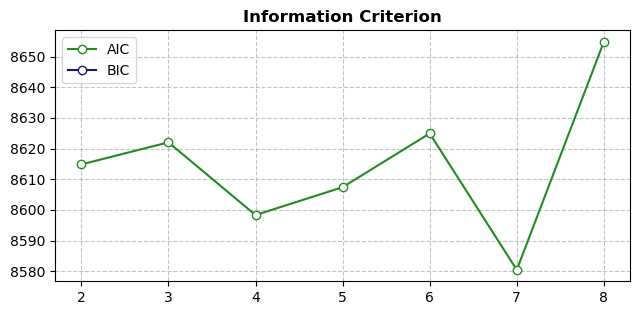

In [3]:
from sklearn import preprocessing
from hmmlearn.hmm import GaussianHMM

trn = rt_ff.loc[cfg.trn_start_dt:cfg.bt_end_dt]  # Training set

states_to_try = range(2, 9)

bic = pd.Series(index=states_to_try, dtype=float)
aic = pd.Series(index=states_to_try, dtype=float)

for n in states_to_try:
    scaler = preprocessing.StandardScaler(copy=True).fit(trn)
    trn_std = scaler.transform(trn)
    mdl = GaussianHMM(
        n_components=n,
        covariance_type=cfg.hm_cov,
        random_state=cfg.hm_rs,
    )
    mdl.fit(trn_std)
    # bic[n] = mdl.bic(trn_std)
    aic[n] = mdl.aic(trn_std)

# Plotting
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6.5, 3.25), sharex=True, sharey=False)
plot_map = {'AIC': (aic, 'forestgreen'), 'BIC': (bic, 'midnightblue')}
# plot_map = {'AIC': (aic, 'forestgreen')}

for i, label in enumerate(plot_map):
    ax.plot(plot_map[label][0], color=plot_map[label][1], marker='o', mfc='white')
    ax.grid(ls='--', alpha=.75)

ax.set_title('Information Criterion', weight='bold')
ax.legend(['AIC', 'BIC'])
plt.tight_layout()
plt.show()

In [4]:
rebalance_dts = pd.date_range(start=cfg.bt_start_dt, end=cfg.bt_end_dt, freq=cfg.rebalance_freq)